# 06. モデルを学習する

【このノートで実施すること】</br>
　まず、データを学習データ、テストデータに分けます。</br>
　学習データは、機械学習モデルの学習に使用するデータです。</br>
　一方、テスト用データは、学習させたモデルの最終的な性能を確認するために使用するデータです。</br>
</br>
　テスト用データをモデルの学習に使用してしまうと、モデルの性能を確認する際にカンニングしているような状態になってしまい、性能を正しく計測できません。</br>
　そのため、テスト用データはモデルの学習には一切使用しないようにします。</br>
</br>
　データを学習データとテストデータに分けたら、学習データのみを使ってモデルを学習します。</br>
　モデルにはLightGBMというフレームワークを使用します。<br>
<br>
　このノートでは、モデルの学習までを実施し、モデルの性能の確認は次のノートで実施します。</br>
</br>
【入力】</br>
　・data/05_target_and_features/df_features.plk</br>
　・data/05_target_and_features/df_target.plk</br>
</br>
【出力】</br>
　・data/06_test_data_and_learned_model/best_lightgbm_model.pkl　（学習済みのモデル）</br>
　・data/06_test_data_and_learned_model/X_test.pkl　（テストデータの説明変数）</br>
　・data/06_test_data_and_learned_model/y_test.pkl　（テストデータの目的変数）</br>
</br>

## 06.1 準備

必要なモジュールをインポートしたり、データを読み込んだりしています。

In [1]:
# 必要なモジュールをインポート
import lightgbm as lgb
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import joblib  # モデルの保存用
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# インストールしてない場合はコメントアウトしてください
import japanize_matplotlib

In [2]:
# 目的変数データを読み込む
with open('data/05_target_and_features/df_target.pkl', 'rb') as file:
    df_target = pickle.load(file)

In [3]:
# 説明変数データを読み込む
with open('data/05_target_and_features/df_features.pkl', 'rb') as file:
    df_features = pickle.load(file)

## 06.2 学習データとテストデータに分ける

データを学習データとテストデータに分けます。<br>
テストデータはモデルの最終的な性能の確認に使用するため、モデルの学習には使用しないようにします。<br>
モデルの性能確認は次のノートで実施するため、テストデータをファイルに保存しておきます。<br>

In [4]:
# データを学習に使用するデータと、テストに使用するデータに分ける
# テストに使用するデータは、機械学習モデルの最終評価に使用するので、学習には使用しない
    
# 目的変数をどれにするか選ぶ
target_col = "3着以内"

# 学習データ８割、テストデータ２割になるようにランダムに分けます。
# X_train: 説明変数 学習データ
# X_test: 説明変数　テストデータ
# y_train: 目的変数　学習データ
# y_test: 目的変数　テストデータ
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target[target_col], test_size=0.2, random_state=42)

In [5]:
# テストデータを保存する
with open('data/06_test_data_and_learned_model/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('data/06_test_data_and_learned_model/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

## 06.3 モデルを学習させる

### 06.3.1 ハイパーパラメータのチューニングとモデル初期化

LightGBMモデルのハイパーパラメータの範囲を定義し、GridSearchCVを用いて最適なパラメータを見つけます。<br>
以下のステップに従って、モデルを初期化し、ハイパーパラメータチューニングを実施します。<br>

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.1, n_estimators=100, num_leaves=30, verbosity=-1;, score=0.809 total time=  58.8s
[CV 2/5] END learning_rate=0.1, n_estimators=100, num_leaves=30, verbosity=-1;, score=0.809 total time= 1.0min
[CV 3/5] END learning_rate=0.1, n_estimators=100, num_leaves=30, verbosity=-1;, score=0.809 total time=  55.2s
[CV 4/5] END learning_rate=0.1, n_estimators=100, num_leaves=30, verbosity=-1;, score=0.808 total time=  56.4s
[CV 5/5] END learning_rate=0.1, n_estimators=100, num_leaves=30, verbosity=-1;, score=0.810 total time=  57.2s
[CV 1/5] END learning_rate=0.1, n_estimators=100, num_leaves=50, verbosity=-1;, score=0.809 total time=  59.3s
[CV 2/5] END learning_rate=0.1, n_estimators=100, num_leaves=50, verbosity=-1;, score=0.808 total time=  59.4s
[CV 3/5] END learning_rate=0.1, n_estimators=100, num_leaves=50, verbosity=-1;, score=0.809 total time=  56.6s
[CV 4/5] END learning_rate=0.1, n_estimators=100, 

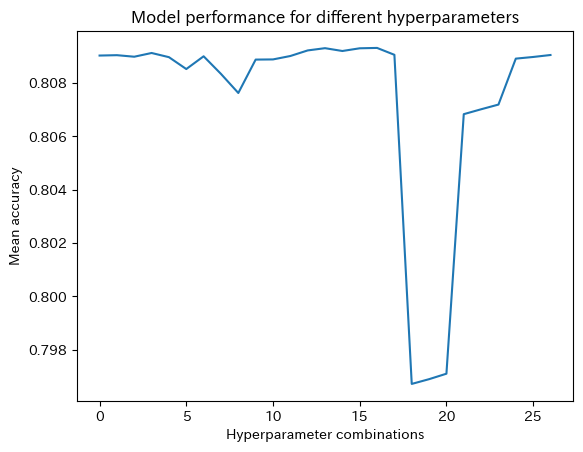

In [6]:
# ハイパーパラメータの設定範囲を定義
param_grid = {
    'num_leaves': [30, 50, 100],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 500],
    'verbosity': [-1]  # 不要なログを抑制
}

# 時間かかりすぎて終わらない！って方はこっちのパラメータを使ってみてください。
# チューニング範囲を狭くして早く終わるようになっています。
# その分モデルの性能は落ちるかもしれません。
# param_grid = {
#     'num_leaves': [30],
#     'learning_rate': [0.1],
#     'n_estimators': [100],
#     'verbosity': [-1]  # 不要なログを抑制
# }


# LightGBMモデルの初期化
model = lgb.LGBMClassifier()

# GridSearchCVの初期化
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=3)

# 時間かかりすぎて終わらない！って方はこっちのパラメータを使ってみてください。
# 交差検証のパターンを減らして早く終わるようになっています。
# その分モデルの性能は落ちるかもしれません。
# grid = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', verbose=3)

# 学習に使わないカラム
drop_col = "KYI_レースキー"
X_train_dropped = X_train.drop(drop_col, axis=1)

# ハイパーパラメータのチューニングとモデルの学習
grid.fit(X_train_dropped, y_train)

# ベストパラメータの表示
print("ベストパラメータ:", grid.best_params_)
print("ベストスコア:", grid.best_score_)

# 学習曲線のプロット
scores = grid.cv_results_['mean_test_score']
plt.plot(scores)
plt.title('Model performance for different hyperparameters')
plt.xlabel('Hyperparameter combinations')
plt.ylabel('Mean accuracy')
plt.show()

### 06.3.2 モデルの再学習

最適なハイパーパラメータを用いて、全訓練データ上でモデルを再学習します。<br>
これにより、モデルが全データを活用してより良い一般化性能を持つようになります。<br>

In [7]:
# 最適なパラメータを用いて、全訓練データでモデルを再学習
best_model = grid.best_estimator_
best_model.fit(X_train_dropped, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=500, num_leaves=50,
               verbosity=-1)

### 06.3.3 モデルの保存

再学習したモデルをファイルに保存します。<br>
モデルを使って予測を実施したい時にはこの学習済みモデルを呼び出すことになります。<br>

In [8]:
# モデルの保存
joblib.dump(best_model, 'data/06_test_data_and_learned_model/best_lightgbm_model.pkl')

['data/06_test_data_and_learned_model/best_lightgbm_model.pkl']

### 06.3.4 特徴量の重要度分析

学習したモデルから特徴量の重要度を取得し、どの特徴量が予測に最も寄与しているのかを分析します。<br>
重要度の高い特徴量を可視化することで、モデルの挙動をより深く理解することができます。<br>

特徴量の重要度:
SED_3走前_ＪＲＤＢデータ_上昇度コード: 994
SED_2走前_ＪＲＤＢデータ_上昇度コード: 968
SED_5走前_ＪＲＤＢデータ_上昇度コード: 914
SED_4走前_ＪＲＤＢデータ_上昇度コード: 912
SED_1走前_ＪＲＤＢデータ_上昇度コード: 877
KYI_重適正コード: 617
KYI_激走指数: 472
KYI_馬番: 435
KYI_総合情報×: 336
SED_1走前_ＪＲＤＢデータ_テン指数: 267
KYI_総合情報△: 239
KYI_性別コード: 222
KYI_レースキー: 219
SED_1走前_ＪＲＤＢデータ_馬ペース: 213
KYI_上昇度: 203
SED_1走前_10時複勝オッズ: 202
KYI_基準人気順位: 200
SED_1走前_馬成績_異常区分: 191
KYI_印コード_総合印: 188
SED_1走前_ＪＲＤＢデータ_ＩＤＭ: 187
KYI_厩舎評価コード: 186
KYI_ローテーション: 184
KYI_万券指数: 174
SED_2走前_ＪＲＤＢデータ_馬ペース: 168
SED_2走前_ＪＲＤＢデータ_テン指数: 166
SED_1走前_ＪＲＤＢデータ_上がり指数: 155
SED_3走前_ＪＲＤＢデータ_馬ペース: 152
SED_1走前_馬成績_斤量: 147
SED_1走前_ＪＲＤＢデータ_素点: 147
KYI_人気指数: 147
KYI_ブリンカー: 144
KYI_総合情報▲: 143
KYI_調教指数: 141
SED_1走前_ＪＲＤＢデータ_馬場差: 141
SED_1走前_ＪＲＤＢデータ_後３Ｆタイム: 139
SED_2走前_ＪＲＤＢデータ_上がり指数: 136
SED_3走前_ＪＲＤＢデータ_テン指数: 134
SED_1走前_レースペース流れ: 134
KYI_特定情報×: 134
SED_1走前_ＪＲＤＢデータ_1(2)着タイム差: 127
KYI_騎手期待連対率: 124
KYI_輸送区分: 123
SED_1走前_10時単勝オッズ: 121
SED_1走前_確定複勝オッズ下: 121
SED_1走前_ＪＲＤＢデータ_レースＰ指数: 120
KYI_ダ適性コード: 119
SED_3走前_ＪＲＤＢデータ_素点: 117
SED_2走前_Ｊ

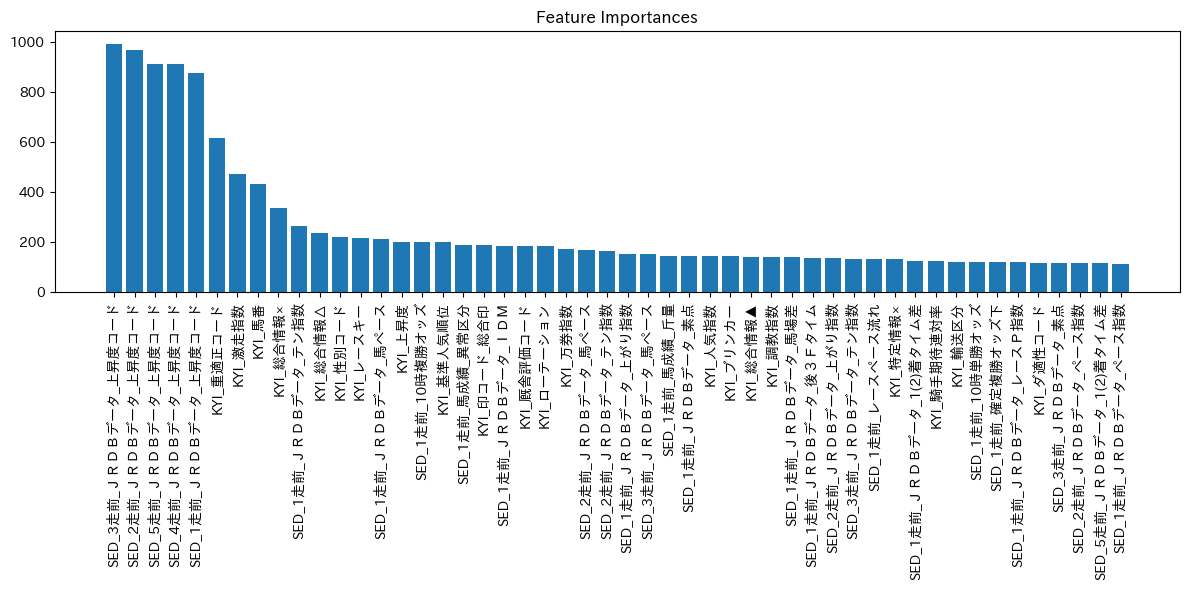

In [9]:
# 特徴量の重要度を取得
feature_importances = best_model.feature_importances_

# 特徴量の名前
feature_names = X_train.columns

# 重要度の高い順に特徴量をソート
sorted_indices = np.argsort(feature_importances)[::-1][:50]

# 重要度の高い順に特徴量とその重要度を表示
print("特徴量の重要度:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]}")

# 特徴量の重要度をプロット
# japanize_matplotlib をインストールしていない場合は文字化けします
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()